# Penerapan Algoritma Machine Learning Klasifikasi
- **Nama:** Muhamad Fajri Permana Haryanto
- **Email:** muhamadfajri2804@gmail.com
- **ID Dicoding:** mijimo



# **1. Import Library**

Beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning ini.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from scipy.stats import randint
from sklearn.model_selection import learning_curve

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file hasil_clustering.CSV ke dalam variabel DataFrame.

In [2]:
retail_df = pd.read_csv("datadicoding/hasil_clustering.csv")
retail_df.head()

,Gender,Age,Quantity,Price per Unit,Total Amount,Product Category_Beauty,Product Category_Books,Product Category_Clothing,Product Category_Electronics,Product Category_Food,Product Category_Home,Quantity_binned,Total_Amount_binned,Cluster
0,1,-0.592433,-0.524125,-1.143912,-0.850306,True,False,False,False,False,False,Low,Low,1
1,0,-1.144961,-0.882137,-0.400108,-0.656939,False,False,True,False,False,False,Low,Low,1
2,1,0.512623,-1.240150,-1.176970,-0.877605,False,False,False,True,False,False,Low,Low,1
3,1,-0.385235,-1.240150,-0.400108,-0.770684,False,False,True,False,False,False,Low,Low,1
4,1,-0.868697,-0.882137,-1.143912,-0.861681,True,False,False,False,False,False,Low,Low,1


In [3]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        2610 non-null   int64  
 1   Age                           2610 non-null   float64
 2   Quantity                      2610 non-null   float64
 3   Price per Unit                2610 non-null   float64
 4   Total Amount                  2610 non-null   float64
 5   Product Category_Beauty       2610 non-null   bool   
 6   Product Category_Books        2610 non-null   bool   
 7   Product Category_Clothing     2610 non-null   bool   
 8   Product Category_Electronics  2610 non-null   bool   
 9   Product Category_Food         2610 non-null   bool   
 10  Product Category_Home         2610 non-null   bool   
 11  Quantity_binned               2610 non-null   object 
 12  Total_Amount_binned           2610 non-null   object 
 13  Clu

In [4]:
print(f"Dataset memiliki {retail_df.shape[0]} baris dan {retail_df.shape[1]} kolom.\n")

Dataset memiliki 2610 baris dan 14 kolom.



In [5]:
print("\nJumlah missing values tiap kolom:")
retail_df.isnull().sum()


Jumlah missing values tiap kolom:


Gender                          0
Age                             0
Quantity                        0
Price per Unit                  0
Total Amount                    0
Product Category_Beauty         0
Product Category_Books          0
Product Category_Clothing       0
Product Category_Electronics    0
Product Category_Food           0
Product Category_Home           0
Quantity_binned                 0
Total_Amount_binned             0
Cluster                         0
dtype: int64

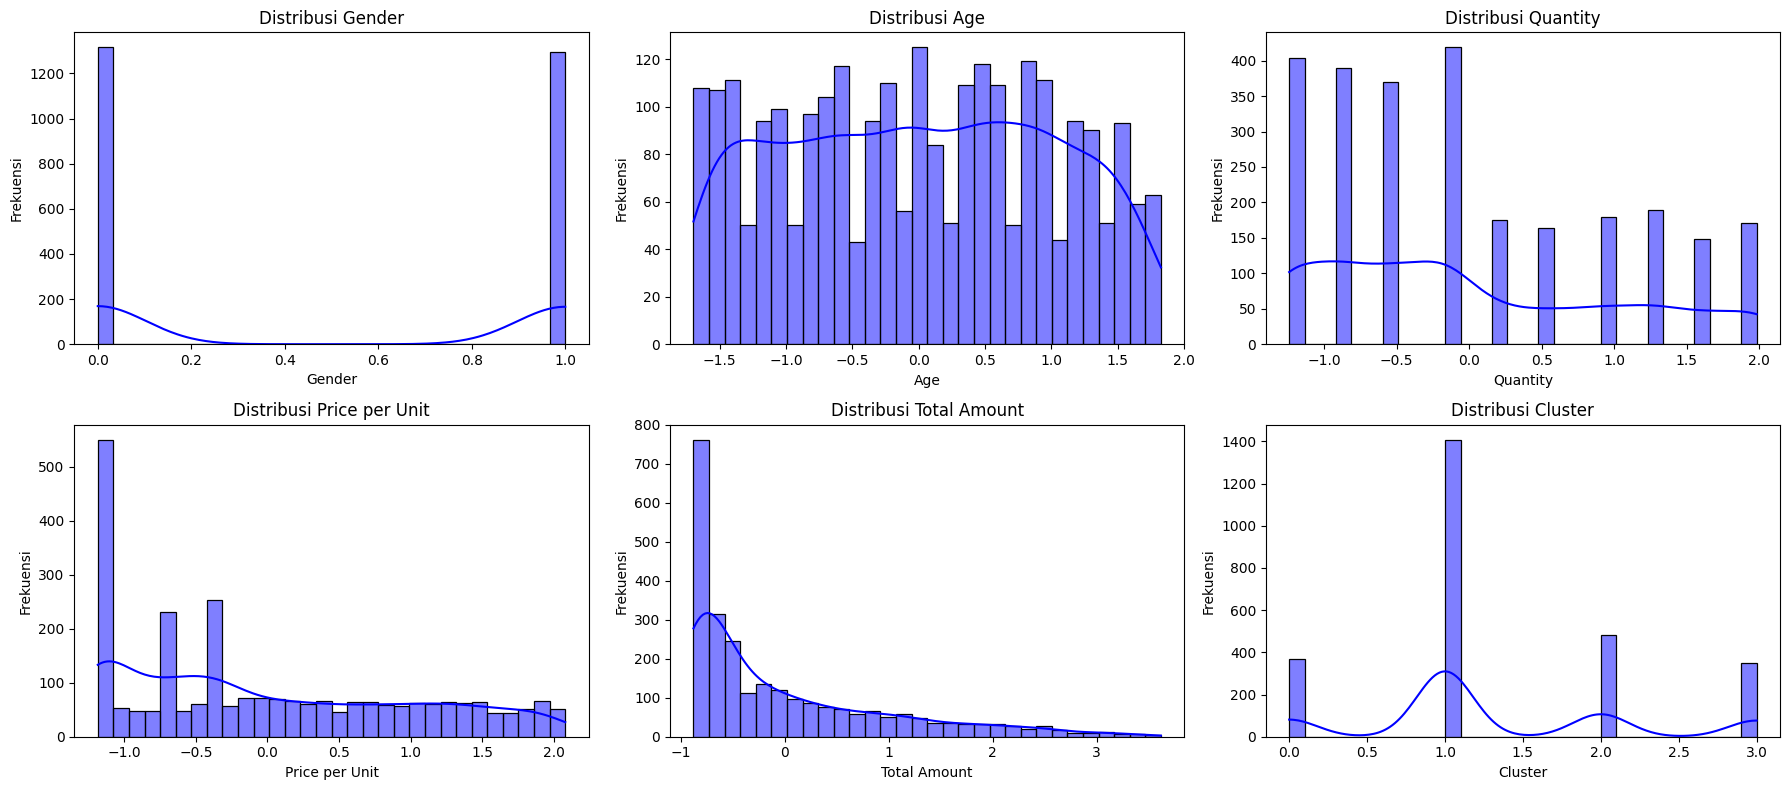

In [6]:
numerical_cols = retail_df.select_dtypes(include=['int64', 'float64']).columns
n_cols = 3
n_rows = (len(numerical_cols) // n_cols) + (len(numerical_cols) % n_cols > 0)
plt.figure(figsize=(n_cols * 6, n_rows * 4))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(retail_df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

**Distribusi target per cluster**

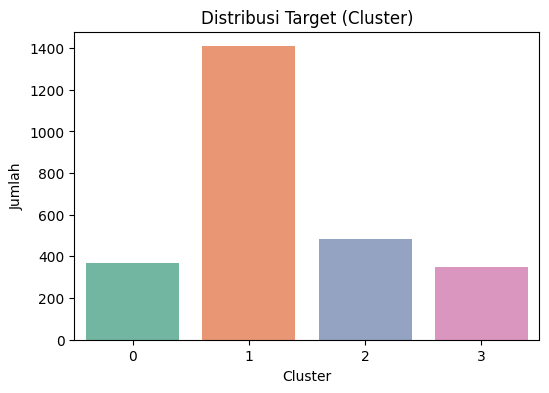

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(data=retail_df, x='Cluster', palette='Set2', hue='Cluster', dodge=False, legend=False)
plt.title('Distribusi Target (Cluster)')
plt.xlabel('Cluster')
plt.ylabel('Jumlah')
plt.show()

# **3. Data Splitting**

## **Laber Encoder**

In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

categorical_columns  = retail_df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    retail_df[col] = label_encoder.fit_transform(retail_df[col])

retail_df.head()


,Gender,Age,Quantity,Price per Unit,Total Amount,Product Category_Beauty,Product Category_Books,Product Category_Clothing,Product Category_Electronics,Product Category_Food,Product Category_Home,Quantity_binned,Total_Amount_binned,Cluster
0,1,-0.592433,-0.524125,-1.143912,-0.850306,True,False,False,False,False,False,1,1,1
1,0,-1.144961,-0.882137,-0.400108,-0.656939,False,False,True,False,False,False,1,1,1
2,1,0.512623,-1.240150,-1.176970,-0.877605,False,False,False,True,False,False,1,1,1
3,1,-0.385235,-1.240150,-0.400108,-0.770684,False,False,True,False,False,False,1,1,1
4,1,-0.868697,-0.882137,-1.143912,-0.861681,True,False,False,False,False,False,1,1,1


## **Memisahkan Data**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set). Untuk itu diambil keputusan 80% data untuk training set dan 20% data untuk test set, untuk data yang digunakannya dilakukan secara acak (random split) untuk memastikan bahwa data yang digunakan untuk training dan testing tidak memiliki bias.

In [9]:
X = retail_df.drop(columns=['Cluster'])
y = retail_df['Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Ukuran data latih: {X_train.shape[0]} baris, {X_train.shape[1]} kolom")
print(f"Ukuran data uji: {X_test.shape[0]} baris, {X_test.shape[1]} kolom")

Ukuran data latih: 2088 baris, 13 kolom
Ukuran data uji: 522 baris, 13 kolom


## **a.Mengecek distribusi target pada training set**

In [10]:
train_distribution = y_train.value_counts()
print("Distribusi Target pada Training Set:")
train_distribution

Distribusi Target pada Training Set:


Cluster
1    1127
2     377
0     303
3     281
Name: count, dtype: int64

## **b.Mengecek distribusi target pada test set**

In [11]:
test_distribution = y_test.value_counts()
print("\nDistribusi Target pada Test Set:")
test_distribution


Distribusi Target pada Test Set:


Cluster
1    281
2    107
3     68
0     66
Name: count, dtype: int64

# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

### Model 1: Random Forest

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Akurasi Random Forest: {rf_accuracy}')

Akurasi Random Forest: 0.9961685823754789


### Model 2: Decision Tree

In [13]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Akurasi Decision Tree: {dt_accuracy}')

Akurasi Decision Tree: 0.9961685823754789


## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

### Model 1: Random Forest

In [14]:
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1_score = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Akurasi Random Forest: {rf_accuracy:.4f}")
print(f"F1-Score Random Forest: {rf_f1_score:.4f}")

print("\nClassification Report Random Forest:")
print(classification_report(y_test, y_pred_rf))

Akurasi Random Forest: 0.9962
F1-Score Random Forest: 0.9962

Classification Report Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        66
           1       1.00      1.00      1.00       281
           2       1.00      0.99      1.00       107
           3       0.97      1.00      0.99        68

    accuracy                           1.00       522
   macro avg       0.99      0.99      0.99       522
weighted avg       1.00      1.00      1.00       522



**Random Forest**

- Akurasi: 99.62%

 - Hasil evaluasi menunjukkan bahwa Random Forest berhasil memprediksi kelas dengan sangat baik, mencapai akurasi sebesar 99.62% pada data uji. Hal ini menunjukkan bahwa model ini mampu mempelajari pola dari data latih dengan sangat baik, meskipun ada sedikit ketidaksempurnaan pada beberapa kelas minoritas.

- F1-Score: 99.62%

 - Dengan F1-Score 99.62%, model ini menunjukkan keseimbangan yang sangat baik antara presisi dan recall, yang menunjukkan bahwa prediksi untuk setiap kelas sangat akurat, terutama pada kelas mayoritas. Model ini memiliki performa sangat baik dalam meminimalkan kesalahan prediksi, baik dalam hal positif maupun negatif.

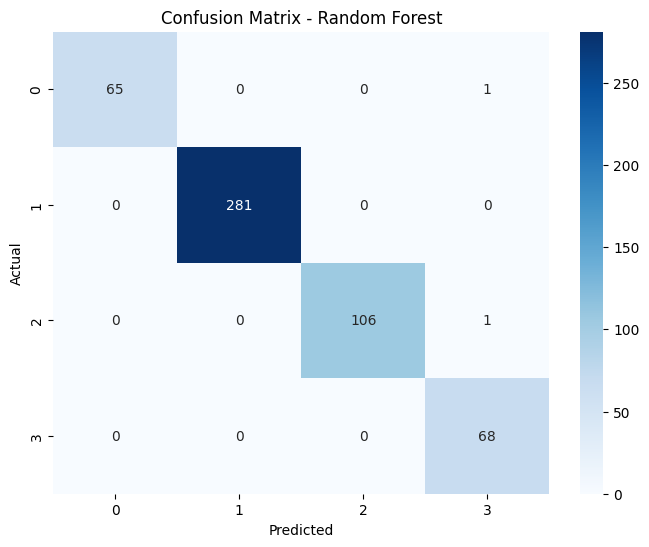

In [15]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Model 2: Decision Tree

In [16]:
y_pred_dt = dt_model.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_f1_score = f1_score(y_test, y_pred_dt, average='weighted')

print(f"Akurasi Decision Tree: {dt_accuracy:.4f}")
print(f"F1-Score Decision Tree: {dt_f1_score:.4f}")

print("\nClassification Report Decision Tree:")
print(classification_report(y_test, y_pred_dt))

Akurasi Decision Tree: 0.9962
F1-Score Decision Tree: 0.9962

Classification Report Decision Tree:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        66
           1       1.00      1.00      1.00       281
           2       1.00      0.99      1.00       107
           3       0.97      1.00      0.99        68

    accuracy                           1.00       522
   macro avg       0.99      0.99      0.99       522
weighted avg       1.00      1.00      1.00       522



**Decision Tree**

- Akurasi: 99.62%
 - Hasil evaluasi menunjukkan bahwa model Decision Tree mencapai akurasi sebesar 99.62% pada data uji. Ini menunjukkan bahwa model ini mampu memprediksi kelas dengan sangat baik, meskipun ada sedikit perbedaan dalam performa pada beberapa kelas minoritas dibandingkan dengan kelas mayoritas.

- F1-Score: 99.62%
 - Dengan F1-Score 99.62%, model Decision Tree menunjukkan keseimbangan yang sangat baik antara presisi dan recall. Model ini berhasil meminimalkan kesalahan prediksi, baik dalam hal positif maupun negatif, meskipun performa sedikit lebih rendah pada kelas dengan jumlah sampel lebih sedikit.

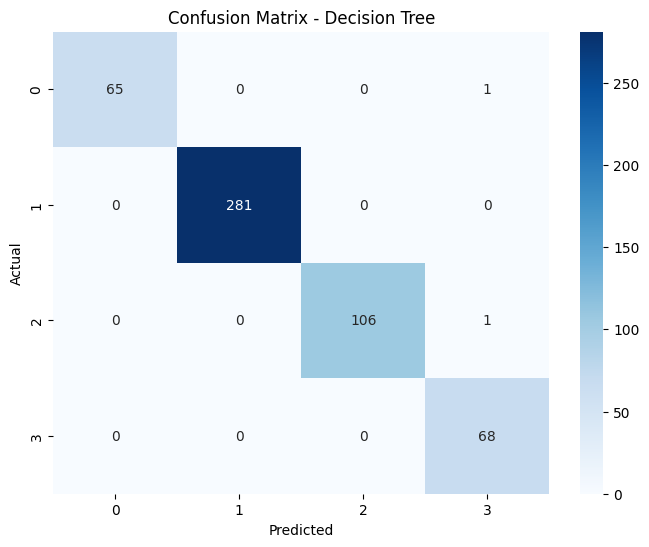

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

karena hasilnnya hampir sempurna baik Akurasi, F1-Score, Precision, dan Recall, perlu dilakukan pengecek kembali apakah terjadi overfiting pada data

In [18]:
train_accuracy = rf_model.score(X_train, y_train)
test_accuracy = rf_model.score(X_test, y_test)

print(f"Akurasi pada Data Latih: {train_accuracy * 100:.2f}%")
print(f"Akurasi pada Data Uji: {test_accuracy * 100:.2f}%")


Akurasi pada Data Latih: 100.00%
Akurasi pada Data Uji: 99.62%


Berdasarkan data tersebut, bisa diketahui bahwa tidak ada indikasi overfitting pada model ini. Meskipun akurasi pada data latih mencapai 100%, perbedaan kecil dengan akurasi pada data uji (99.62%) menunjukkan bahwa model dapat generalisasi dengan baik tanpa mempelajari noise pada data latih.

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

### Random Forest RandomizedSearchCV

In [19]:
param_dist_rf = {
    'n_estimators': randint(50, 200),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

rf_model = RandomForestClassifier(random_state=42)
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist_rf, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train, y_train)
print(f'Best Parameters for Random Forest: {random_search_rf.best_params_}')

Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}


**hasil yang didapat (Random Forest dengan metode RandomizedSearchCV):**
- max_depth: 10
 - Model membatasi kedalaman pohon hingga 10, yang membantu mencegah model terlalu kompleks dan mengurangi risiko overfitting. Kedalaman ini cukup untuk memisahkan data secara efektif tanpa membuat model terlalu rumit.

- min_samples_leaf: 1
 - Setiap daun pohon dapat berisi hanya 1 sampel, memungkinkan model untuk membagi data dengan lebih fleksibel dan menangani variasi yang lebih kecil pada data.

- min_samples_split: 2
 - Untuk membagi sebuah node, model membutuhkan minimal 2 sampel. Hal ini memungkinkan pembentukan pohon yang lebih dalam dan lebih kompleks, yang dapat memperbaiki pemisahan data yang lebih rumit.

- n_estimators: 120
 - Model ini terdiri dari 120 pohon keputusan, yang meningkatkan akurasi prediksi dan mengurangi variabilitas dengan menggabungkan hasil dari lebih banyak pohon, sehingga memperbaiki stabilitas dan generalisasi model.

### Decision Tree RandomizedSearchCV

In [20]:
param_dist_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

dt_model = DecisionTreeClassifier(random_state=42)
random_search_dt = RandomizedSearchCV(estimator=dt_model, param_distributions=param_dist_dt, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search_dt.fit(X_train, y_train)
print(f'Best Parameters for Decision Tree: {random_search_dt.best_params_}')

Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 8}


**hasil yang didapat (Decision Tree dengan metode RandomizedSearchCV):**
- max_depth: None
 - Model tidak membatasi kedalaman pohon, memungkinkan pohon tumbuh hingga kedalaman yang diperlukan untuk memisahkan data dengan baik. Ini memberikan fleksibilitas untuk menangani kompleksitas data tanpa pembatasan.

- min_samples_leaf: 1
 - Setiap daun pohon dapat berisi minimal 1 sampel, yang memungkinkan model untuk lebih fleksibel dalam memisahkan data dan menangani variasi kecil.

- min_samples_split: 8
 - Untuk membagi sebuah node, diperlukan minimal 8 sampel. Hal ini memastikan bahwa pembagian node hanya terjadi ketika ada cukup sampel untuk membuat keputusan yang lebih stabil, mengurangi risiko pembagian yang tidak bermakna atau terlalu spesifik.



## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

### **Evaluasi untuk Random Forest setelah penerapan RandomizedSearchCV**

In [21]:
rf_best_model = RandomForestClassifier(max_depth=None, min_samples_leaf=4, min_samples_split=6, n_estimators=64, random_state=42)
rf_best_model.fit(X_train, y_train)
y_pred_rf = rf_best_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')
rf_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_recall = recall_score(y_test, y_pred_rf, average='weighted')

print(f'Random Forest - Akurasi: {rf_accuracy}')
print(f'Random Forest - F1-Score: {rf_f1}')
print(f'Random Forest - Precision: {rf_precision}')
print(f'Random Forest - Recall: {rf_recall}')

Random Forest - Akurasi: 0.9961685823754789
Random Forest - F1-Score: 0.9961845374365703
Random Forest - Precision: 0.9962780514504652
Random Forest - Recall: 0.9961685823754789


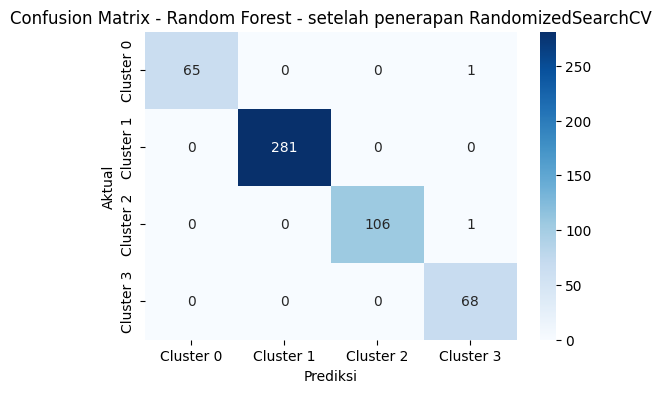

In [22]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Cluster {i}' for i in range(len(set(y)))], yticklabels=[f'Cluster {i}' for i in range(len(set(y)))])
plt.title("Confusion Matrix - Random Forest - setelah penerapan RandomizedSearchCV")
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

### **Evaluasi untuk Decision Tree setelah penerapan RandomizedSearchCV**

In [23]:
dt_best_model = DecisionTreeClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=6, random_state=42)
dt_best_model.fit(X_train, y_train)
y_pred_dt = dt_best_model.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt, average='weighted')
dt_precision = precision_score(y_test, y_pred_dt, average='weighted')
dt_recall = recall_score(y_test, y_pred_dt, average='weighted')

print(f'Decision Tree - Akurasi: {dt_accuracy}')
print(f'Decision Tree - F1-Score: {dt_f1}')
print(f'Decision Tree - Precision: {dt_precision}')
print(f'Decision Tree - Recall: {dt_recall}')

Decision Tree - Akurasi: 0.9942528735632183
Decision Tree - F1-Score: 0.9942569542086841
Decision Tree - Precision: 0.9943691359318652
Decision Tree - Recall: 0.9942528735632183


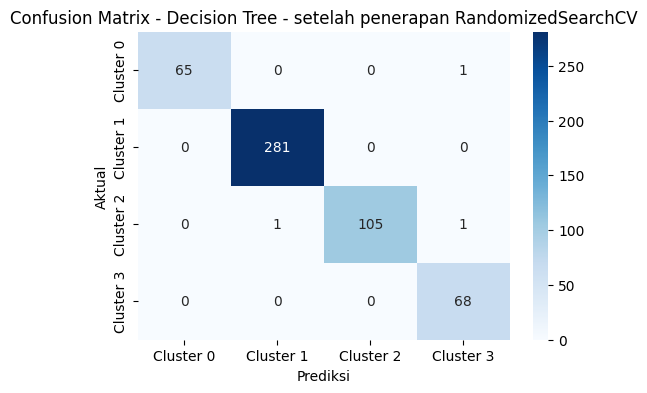

In [24]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Cluster {i}' for i in range(len(set(y)))], yticklabels=[f'Cluster {i}' for i in range(len(set(y)))])
plt.title("Confusion Matrix - Decision Tree - setelah penerapan RandomizedSearchCV")
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

In [25]:
y_train_pred = rf_best_model.predict(X_train)
y_test_pred = rf_best_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Akurasi Data Latih: {train_accuracy:}")
print(f"Akurasi Data Uji: {test_accuracy:}")

Akurasi Data Latih: 0.9990421455938697
Akurasi Data Uji: 0.9961685823754789


### Menghitung learning curve Random Forest

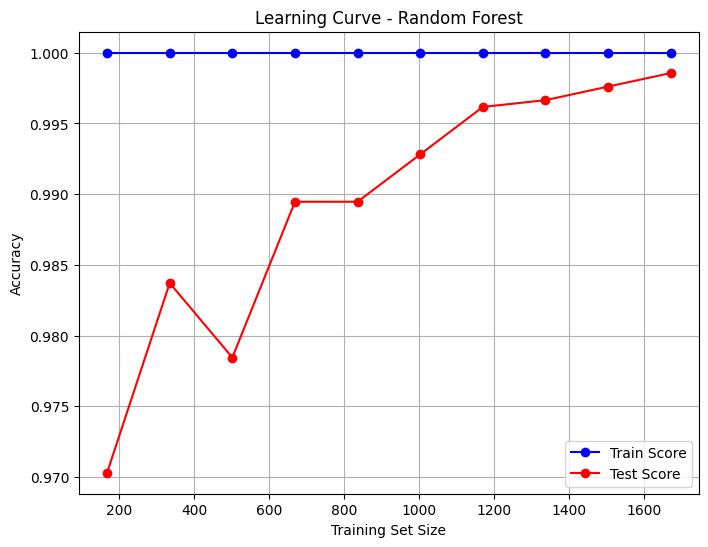

In [26]:

train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Train Score", color='blue', marker='o')
plt.plot(train_sizes, test_mean, label="Test Score", color='red', marker='o')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

### Menghitung learning curve Decision Tree

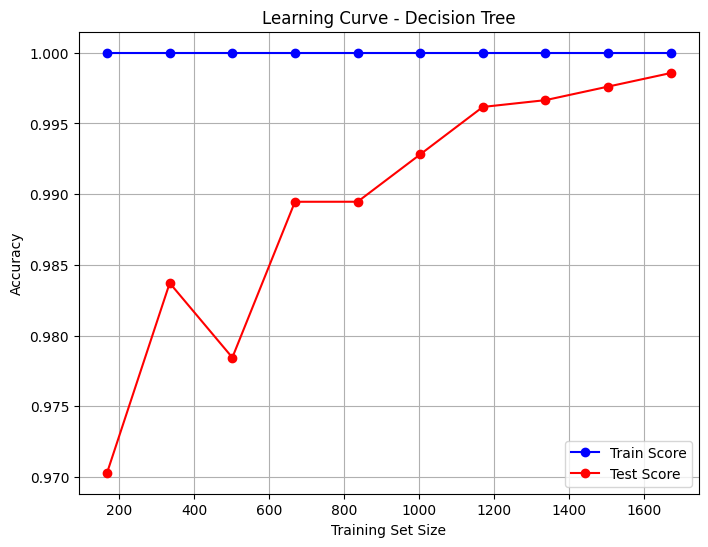

In [27]:
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Train Score", color='blue', marker='o')
plt.plot(train_sizes, test_mean, label="Test Score", color='red', marker='o')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Decision Tree")
plt.legend()
plt.grid(True)
plt.show()

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).


- **Untuk yang Random Forest**
 - Hasil evaluasi menunjukkan bahwa tidak ada perubahan signifikan pada performa model Random Forest sebelum dan setelah tuning menggunakan RandomizedSearchCV. Akurasi tetap 99.62%, dan F1-Score tetap 0.9962, menunjukkan keseimbangan yang baik antara presisi dan recall. Meskipun precision dan recall sedikit menurun setelah tuning (precision menjadi 0.9963 dan recall 0.9962), perubahan ini tidak signifikan. Secara keseluruhan, model sudah optimal sejak awal, dan tuning hanya memberikan peningkatan minor yang tidak berdampak besar pada hasil akhir.

- **Untuk yang Decision Tree**
 - Evaluasi model Decision Tree sebelum dan setelah tuning dengan RandomizedSearchCV menunjukkan hasil yang sangat baik meskipun ada perbedaan kecil. Sebelum tuning, akurasi mencapai 99.62% dan F1-Score 0.9962, dengan nilai precision dan recall hampir sempurna. Setelah tuning, akurasi sedikit menurun menjadi 99.43%, dan F1-Score menjadi 0.9943, dengan penurunan kecil pada precision dan recall. Meskipun ada penurunan minor, model tetap menunjukkan performa yang sangat baik, dengan sedikit perbaikan setelah tuning. Secara keseluruhan, tuning tidak memberikan perubahan besar dan model sudah optimal sejak awal.

2. Identifikasi kelemahan model, seperti:

  - **Precision atau Recall rendah untuk kelas tertentu.**
    - Pada hasil evaluasi, Precision dan Recall untuk kelas 3 (label 3) lebih rendah dibandingkan kelas lainnya. Untuk Precision, nilai pada kelas 3 adalah 0.97, dan untuk Recall adalah 1.00. Penurunan Precision ini menunjukkan bahwa model cenderung memberikan false positives lebih banyak pada kelas ini, meskipun recall-nya tetap tinggi.
    
    - karena Recall yang sangat tinggi menunjukkan bahwa sebagian besar data kelas 3 berhasil diprediksi dengan benar. Secara keseluruhan, model masih efektif.

  - Apakah model mengalami overfitting atau underfitting?
    - Overfitting: Meskipun akurasi pada **data latih sangat tinggi (99.90%)** dan akurasi pada **data uji juga sangat baik (99.62%)**, tidak ada indikasi kuat overfitting. Model masih menunjukkan performa yang konsisten pada data uji, yang berarti model tidak terlalu "terlatih" pada data latih dan dapat generalisasi dengan baik ke data uji.

    - Underfitting: Model tidak menunjukkan tanda-tanda underfitting karena akurasi dan F1-Score yang tinggi pada kedua data latih dan uji menunjukkan bahwa model mampu menangani data dengan sangat baik, tanpa kesulitan dalam mempelajari pola dari data.


3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

 - Tidak perlu tuning lebih lanjut: Model sudah optimal dengan akurasi 99.62%.
 - Kumpulkan lebih banyak data: Menambah data dapat membantu model lebih menggeneralisasi.
 - Coba algoritma lain: Eksplorasi algoritma seperti SVM atau KNN untuk perbandingan performa.